# Bonus1: Parallel Algorithms (Decentralized Optimization)

### Name: Mijeong Ban


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01440312 -0.16143462 -0.03002923 -0.06298736 -0.08457043 -0.2114895
  -0.02500507 -0.00389161]]
test std = 
[[1.00773362 0.88344705 0.94643579 0.96671905 0.94169399 1.19426339
  0.91621837 1.05488628]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 1.5 Worker Nodes

In [5]:
class Worker:
    def __init__(self, x, y, lam, learning_rate, weight, ID):
        self.x = x
        self.y = y
        self.lam = lam
        self.learning_rate = learning_rate
        self.w = numpy.zeros([x.shape[1], 1])
        self.neighbors = []
        self.neighbor_weights = []
        self.size = 0
        self.weight = weight
        self.ID = ID
        
    def add_neighbor(self, worker_IDs):
        for i in range(len(worker_IDs)):
            self.neighbors.append(worker_IDs[i])
            self.neighbor_weights.append(numpy.zeros_like(self.w))
            self.size = self.size+1
    
    def get_neighbor_ID(self):
        return self.neighbors

    def get_weight(self, ID, w):
        for i in range(self.size):
            if self.neighbors[i] == ID:
                self.neighbor_weights[i] = w
    
    def broadcast(self):
        return self.w
    
    def loss(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1 + vec1)
        return numpy.sum(vec2)/x.shape[0]

    def gradient(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(yxw)
        vec2 = numpy.divide(-yx, 1 + vec1)
        g = numpy.sum(vec2, axis=0).reshape(self.x.shape[1], 1)
        g = g/self.x.shape[0]
        self.updated_weight()
        self.w = self.w - self.learning_rate*(g + self.lam*self.w)
        
    def updated_weight(self):
        w_base = 0
        w_base += self.weight * self.w
        for i in range(self.size):
            w_base = w_base + self.neighbor_weights[i]
        self.w = w_base/(self.size+1)  

## 1.6 Decentralized Optimization without weighted averaging

### 1.6.1 Worker Initialization 

In [6]:
learning_rate = 1E-1
lam = 1E-6
weight = 1

node_0 = Worker(x_train,y_train,lam,learning_rate,weight,"0")
node_1 = Worker(x_train,y_train,lam,learning_rate,weight,"1")
node_2 = Worker(x_train,y_train,lam,learning_rate,weight,"2")
node_3 = Worker(x_train,y_train,lam,learning_rate,weight,"3")
node_4 = Worker(x_train,y_train,lam,learning_rate,weight,"4")
node_5 = Worker(x_train,y_train,lam,learning_rate,weight,"5")
node_6 = Worker(x_train,y_train,lam,learning_rate,weight,"6")
node_0.add_neighbor(["1","2"])
node_1.add_neighbor(["0","2","3"])
node_2.add_neighbor(["0","1","4"])
node_3.add_neighbor(["1","4","5","6"])
node_4.add_neighbor(["2","3"])
node_5.add_neighbor(["4","6"])
node_6.add_neighbor(["4","5"])

### 1.6.2 Performing Parallel GD

In [7]:
def decentralized_gd(node, IDs, w):
    for i in range(len(IDs)):
        node.get_weight(IDs[i], w[i])
    node.gradient()
    updated_w = node.broadcast()
    loss = node.loss()
    return node, loss, updated_w

In [8]:
epoch = 50
w_0 = numpy.zeros([x_train.shape[1], 1])
w_1 = numpy.zeros([x_train.shape[1], 1])
w_2 = numpy.zeros([x_train.shape[1], 1])
w_3 = numpy.zeros([x_train.shape[1], 1])
w_4 = numpy.zeros([x_train.shape[1], 1])
w_5 = numpy.zeros([x_train.shape[1], 1])
w_6 = numpy.zeros([x_train.shape[1], 1])

objective_values = []
for i in range(epoch):
    losses = 0
    node_0_neighbor_weights = [w_1, w_2]
    node_0, loss, w_0 = decentralized_gd(node_0, node_0.get_neighbor_ID(), node_0_neighbor_weights)
    losses += loss
    
    node_1_neighbor_weights = [w_0, w_2, w_3]
    node_1, loss, w_1 = decentralized_gd(node_1, node_1.get_neighbor_ID(), node_1_neighbor_weights)
    losses += loss
    
    node_2_neighbor_weights = [w_0, w_1, w_4]
    node_2, loss, w_2 = decentralized_gd(node_2, node_2.get_neighbor_ID(), node_2_neighbor_weights)
    losses += loss
    
    node_3_neighbor_weights = [w_1, w_4, w_5, w_6]
    node_3, loss, w_3 = decentralized_gd(node_3, node_3.get_neighbor_ID(), node_3_neighbor_weights)
    losses += loss
    
    node_4_neighbor_weights = [w_2, w_3]
    node_4, loss, w_4 = decentralized_gd(node_4, node_4.get_neighbor_ID(), node_4_neighbor_weights)
    losses += loss
    
    node_5_neighbor_weights = [w_4, w_6]
    node_5, loss, w_5 = decentralized_gd(node_5, node_5.get_neighbor_ID(), node_5_neighbor_weights)
    losses += loss
    
    node_6_neighbor_weights = [w_4, w_5]
    node_6, loss, w_6 = decentralized_gd(node_6, node_6.get_neighbor_ID(), node_6_neighbor_weights)
    losses += loss
    
    obj = losses/7
    objective_values.append(obj)
print(objective_values)

[0.5620560117861922, 0.5477738131559821, 0.5351573008062863, 0.5240475337229955, 0.5142373126520544, 0.5055382163902212, 0.49778929150249923, 0.4908552325415374, 0.4846227465292423, 0.47899695375331575, 0.47389822844391327, 0.4692595355076627, 0.4650242259679116, 0.4611442288279495, 0.4575785745987903, 0.45429219141573923, 0.4512549229652029, 0.4484407259606346, 0.4458270126435293, 0.44339411040722915, 0.44112481612492244, 0.439004027217924, 0.43701843507875454, 0.435156269320004, 0.4334070835930083, 0.4317615755273635, 0.43021143477940393, 0.42874921432235535, 0.4273682210243898, 0.42606242229179697, 0.4248263661411221, 0.42365511253637517, 0.4225441742088331, 0.4214894654860455, 0.42048725790796143, 0.4195341416131369, 0.4186269916458108, 0.4177629384724964, 0.4169393421103179, 0.4161537693632318, 0.4154039737401424, 0.41468787769370585, 0.41400355687266915, 0.4133492261258282, 0.4127232270336539, 0.41212401677559213, 0.41155015816800994, 0.41100031073058674, 0.4104732226583089, 0.40

## 1.7 Decentralized Optimization with weighted averaging

### 1.7.1 Worker Initialization

In [9]:
learning_rate = 2E-1
lam = 1E-6
weight = 1.03

node_0 = Worker(x_train,y_train,lam,learning_rate,weight,"0")
node_1 = Worker(x_train,y_train,lam,learning_rate,weight,"1")
node_2 = Worker(x_train,y_train,lam,learning_rate,weight,"2")
node_3 = Worker(x_train,y_train,lam,learning_rate,weight,"3")
node_4 = Worker(x_train,y_train,lam,learning_rate,weight,"4")
node_5 = Worker(x_train,y_train,lam,learning_rate,weight,"5")
node_6 = Worker(x_train,y_train,lam,learning_rate,weight,"6")
node_0.add_neighbor(["1","2"])
node_1.add_neighbor(["0","2","3"])
node_2.add_neighbor(["0","1","4"])
node_3.add_neighbor(["1","4","5","6"])
node_4.add_neighbor(["2","3"])
node_5.add_neighbor(["4","6"])
node_6.add_neighbor(["4","5"])

### 1.7.2 Performing Parallel GD

In [10]:
w_0 = numpy.zeros([x_train.shape[1], 1])
w_1 = numpy.zeros([x_train.shape[1], 1])
w_2 = numpy.zeros([x_train.shape[1], 1])
w_3 = numpy.zeros([x_train.shape[1], 1])
w_4 = numpy.zeros([x_train.shape[1], 1])
w_5 = numpy.zeros([x_train.shape[1], 1])
w_6 = numpy.zeros([x_train.shape[1], 1])

objective_values_with_weight = []
for i in range(epoch):
    losses = 0
    node_0_neighbor_weights = [w_1, w_2]
    node_0, loss, w_0 = decentralized_gd(node_0, node_0.get_neighbor_ID(), node_0_neighbor_weights)
    losses += loss
    
    node_1_neighbor_weights = [w_0, w_2, w_3]
    node_1, loss, w_1 = decentralized_gd(node_1, node_1.get_neighbor_ID(), node_1_neighbor_weights)
    losses += loss
    
    node_2_neighbor_weights = [w_0, w_1, w_4]
    node_2, loss, w_2 = decentralized_gd(node_2, node_2.get_neighbor_ID(), node_2_neighbor_weights)
    losses += loss
    
    node_3_neighbor_weights = [w_1, w_4, w_5, w_6]
    node_3, loss, w_3 = decentralized_gd(node_3, node_3.get_neighbor_ID(), node_3_neighbor_weights)
    losses += loss
    
    node_4_neighbor_weights = [w_2, w_3]
    node_4, loss, w_4 = decentralized_gd(node_4, node_4.get_neighbor_ID(), node_4_neighbor_weights)
    losses += loss
    
    node_5_neighbor_weights = [w_4, w_6]
    node_5, loss, w_5 = decentralized_gd(node_5, node_5.get_neighbor_ID(), node_5_neighbor_weights)
    losses += loss
    
    node_6_neighbor_weights = [w_4, w_5]
    node_6, loss, w_6 = decentralized_gd(node_6, node_6.get_neighbor_ID(), node_6_neighbor_weights)
    losses += loss
    
    obj = losses/7
    objective_values_with_weight.append(obj)
print(objective_values_with_weight)

[0.5475656395965339, 0.5230247459751981, 0.5036630853131372, 0.4882360208531987, 0.4757484581237514, 0.4654762190505949, 0.4568997943348122, 0.4496444941824878, 0.4434365493831819, 0.438072718577565, 0.43339958340332796, 0.42929942647467073, 0.42568051009620655, 0.4224702977450146, 0.41961065941710335, 0.4170544302928662, 0.4147629050398562, 0.41270398801131575, 0.4108508095945306, 0.40918067829006566, 0.40767427768715786, 0.40631504425011566, 0.4050886801396731, 0.4039827679832331, 0.40298646341037625, 0.4020902474881044, 0.4012857257239517, 0.400565463592553, 0.39992285094886626, 0.3993519894712044, 0.3988475986050087, 0.39840493647725583, 0.3980197330091113, 0.3976881330336609, 0.3974066476716356, 0.39717211256406537, 0.39698165183103573, 0.39683264683819697, 0.3967227090207868, 0.39664965614876835, 0.3966114915238769, 0.39660638568570955, 0.3966326602739269, 0.3966887737505885, 0.39677330873326006, 0.3968849607278858, 0.39702252808212146, 0.3971849030061571, 0.39737106353002494, 0.

## 1.8 Results

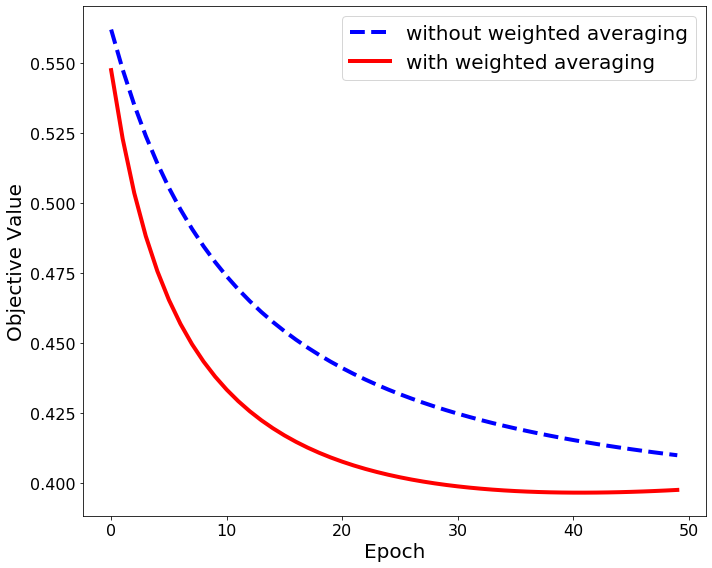

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(10, 8))

epochs_gd = range(epoch)

line0, = plt.plot(epochs_gd, objective_values, '--b', LineWidth=4)
line1, = plt.plot(epochs_gd, objective_values_with_weight, '-r', LineWidth=4)

plt.xlabel('Epoch', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0,line1], ['without weighted averaging','with weighted averaging'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_weights.pdf', format='pdf', dpi=1200)